## Simulating the eBOSS Instrument

This notebook goes through how to simulate eBOSS spectra given a source model. The source here is the same reference source used in the default `desi` configuration, adjusted so that it covers the wavelength range required for interpolated over the `eboss` wavelength grid. 

In [17]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Users/belaabolfathi/anaconda3/envs/galsim/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['vstack']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [18]:
import specsim.simulator

from astropy.io import fits
from astropy.table import Table, vstack

#### Prepare source model to be read from config file

In [23]:
sourceAB = Table.read('/Users/belaabolfathi/Data/desimodel/data/spectra/spec-ABmag22.0.dat', format='ascii')

We need to pad the source model so that it extends beyond the the wavelength grid in the config file:

In [26]:
beg = np.arange(2000, np.min(sourceAB['WAVELENGTH']), 0.1)
end = np.arange(np.max(sourceAB['WAVELENGTH']), 11000, 0.1)
col_beg = np.full(len(beg), sourceAB['FLUX'][0])
col_end = np.full(len(end), sourceAB['FLUX'][-1])
pad_beg = Table([beg, col_beg], names=('WAVELENGTH', 'FLUX'))
pad_end = Table([end, col_end], names=('WAVELENGTH', 'FLUX'))
adjusted_source = vstack([pad_beg, sourceAB])
adjusted_source = vstack([new_data, pad_end])

In [31]:
adjusted_source.write('/Users/belaabolfathi/Documents/repos/specsim/specsim/data/sdss/spectra/spec-ABmag22.0.dat', 
               format='ascii', overwrite=True)

#adjusted_source = Table.read('/Users/belaabolfathi/Documents/repos/specsim/specsim/data/sdss/spectra/spec-ABmag22.0.dat', 
            #format='ascii)

#### Compare specsim output in DESI and eBOSS modes

##### Initialize each simulator

In [30]:
desi = specsim.simulator.Simulator('desi', num_fibers=1, camera_output=True)
eboss = specsim.simulator.Simulator('eboss', num_fibers=1, camera_output=True)

##### Get simulated output for each camera

In [ ]:
def get_camera_output(simulator):
    
    simulator.simulate()
    simulator.generate_random_noise()
    sim = simulator.simulated
    cam1 = simulator.camera_output[0]
    cam2 = simulator.camera_output[1]
    
    if simulator == desi:
        cam3 = simulator.camera_output[2]
        return(cam1, cam2, cam3)
    
    else:
        return(cam1, cam2)
    
desi_cam1, desi_cam2, desi_cam3 = get_camera_output(desi)
eboss_cam1, eboss_cam2 = get_camera_output(eboss)

##### Interpolate output to have 1Å binning

In [32]:
def adjust_wavelength_grid(wlen, func):
    lo, hi = np.min(wlen), np.max(wlen)
    grid = np.arange(lo, hi, 1.0)
    return(grid, np.interp(grid, wlen, func))

source_wlen, source_flux = adjust_wavelength_grid(adjusted_source['WAVELENGTH'], adjusted_source['FLUX'])

desi_wlen1, desi_ivar1 = adjust_wavelength_grid(desi_cam1['wavelength'], desi_cam1['flux_inverse_variance'][:,0])
desi_wlen2, desi_ivar2 = adjust_wavelength_grid(desi_cam2['wavelength'], desi_cam2['flux_inverse_variance'][:,0])
desi_wlen3, desi_ivar3 = adjust_wavelength_grid(desi_cam3['wavelength'], desi_cam3['flux_inverse_variance'][:,0])

eboss_wlen1, eboss_ivar1 = adjust_wavelength_grid(eboss_cam1['wavelength'], eboss_cam1['flux_inverse_variance'][:,0])
eboss_wlen2, eboss_ivar2 = adjust_wavelength_grid(eboss_cam2['wavelength'], eboss_cam2['flux_inverse_variance'][:,0])

##### Plot DESI and eBOSS (simulated) inverse variance

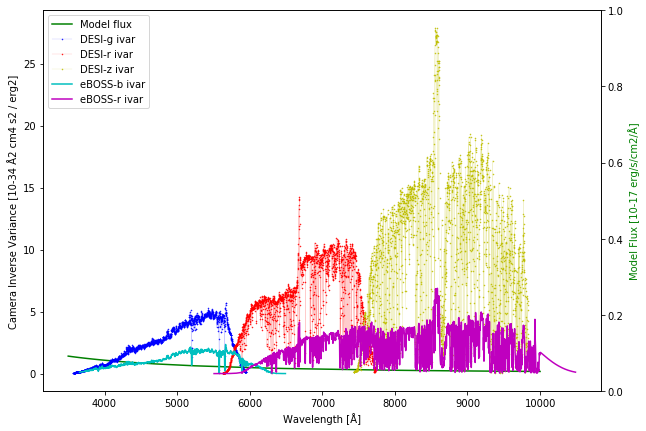

In [34]:
fig, ax1 = plt.subplots(figsize=(10,7))

ax2 = ax1.twinx()
ax1.plot(sourceAB['WAVELENGTH'], sourceAB['FLUX'], 'g', label='Model flux') # 1e-17 erg/s/cm2/A
ax1.plot(desi_wlen1, desi_ivar1 * 1e-34, 'b.-', ms=1, lw=0.1, label='DESI-g ivar') # 1e34 A2 cm4 s2 / erg2
ax1.plot(desi_wlen2, desi_ivar2 * 1e-34, 'r.-',  ms=1, lw=0.1, label='DESI-r ivar') # 1e34 A2 cm4 s2 / erg2
ax1.plot(desi_wlen3, desi_ivar3 * 1e-34, 'y.-',  ms=1, lw=0.1, label='DESI-z ivar') # 1e34 A2 cm4 s2 / erg2
ax1.plot(eboss_wlen1, eboss_ivar1 * 1e-34, 'c', label='eBOSS-b ivar') # 1e34 A2 cm4 s2 / erg2
ax1.plot(eboss_wlen2, eboss_ivar2 * 1e-34, 'm', label='eBOSS-r ivar') # 1e34 A2 cm4 s2 / erg2

ax1.legend(loc=2)
ax1.set_xlabel('Wavelength [Å]')
ax1.set_ylabel('Camera Inverse Variance [10-34 Å2 cm4 s2 / erg2]', color='k')
ax2.set_ylabel('Model Flux [10-17 erg/s/cm2/Å]', color='g')
plt.show()

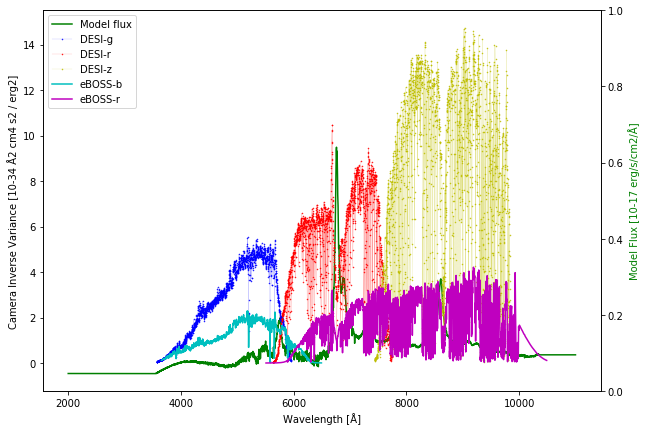

In [24]:
fig, ax1 = plt.subplots(figsize=(10,7))

ax2 = ax1.twinx()
ax1.plot(qso_wlen, qso_flux, 'g', label='Model flux') # 1e-17 erg/s/cm2/A
ax1.plot(desi_wlen1, desi_ivar1 * 1e-34, 'b.-', ms=1, lw=0.1, label='DESI-g') # 1e34 A2 cm4 s2 / erg2
ax1.plot(desi_wlen2, desi_ivar2 * 1e-34, 'r.-',  ms=1, lw=0.1, label='DESI-r') # 1e34 A2 cm4 s2 / erg2
ax1.plot(desi_wlen3, desi_ivar3 * 1e-34, 'y.-',  ms=1, lw=0.1, label='DESI-z') # 1e34 A2 cm4 s2 / erg2
ax1.plot(eboss_wlen1, eboss_ivar1 * 1e-34, 'c', label='eBOSS-b') # 1e34 A2 cm4 s2 / erg2
ax1.plot(eboss_wlen2, eboss_ivar2 * 1e-34, 'm', label='eBOSS-r') # 1e34 A2 cm4 s2 / erg2

ax1.legend(loc=2)
ax1.set_xlabel('Wavelength [Å]')
ax1.set_ylabel('Camera Inverse Variance [10-34 Å2 cm4 s2 / erg2]', color='k')
ax2.set_ylabel('Model Flux [10-17 erg/s/cm2/Å]', color='g')
plt.show()